In [86]:
import pandas as pd
from datetime import datetime
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pickle
from scipy.ndimage import label

In [87]:
filename ="/home/cr2/cmtorres/repos/Patagonia-Antarctic_Peninsula/data/HWs_AWS_AP.pkl" 
with open(filename, "rb") as f:
    HWs_PA = pickle.load(f)    


In [88]:
file = '/home/cr2/cmtorres/repos/Patagonia-Antarctic_Peninsula/data/CLIMS_AP.txt'
df_meta = pd.read_csv(file, sep=';')
df_meta

,Name,lat,lon,Ele
0,Esperanza,-63.400000,-56.983333,13
1,Marambio,-64.233333,-56.716667,198
2,Vernadsky,-65.250000,-64.266667,11
3,Rothera,-67.570020,-68.123610,16


In [89]:

def heatwave_labels(df):
    """
    Extracts heatwave events from a DataFrame containing identified heatwaves.

    Parameters:
    - df: DataFrame with columns ['date', 'temperature', 'p90_har', 'heatwave']

    Returns:
    - DataFrame with columns ['start_date', 'duration', 'max_temperature']
    """
    heatwave_labels, num_features = label(df["heatwave"].values)
    df_label = df.copy()
    df_label["label"] = heatwave_labels
    
    return df_label


In [90]:
HWs_lb = []
for i in range(0, len(HWs_PA)):
    HWs_lb.append(heatwave_labels(HWs_PA[i]))

# Suponiendo que cada DataFrame tiene una columna 'date' en formato datetime
HWs_lb_nov_mar = []

for df in HWs_lb:
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])  # Asegura que sea datetime
    df['month'] = df['date'].dt.month
    df_filtered = df[df['month'].isin([11, 12, 1, 2, 3])].copy()
    df_filtered.drop(columns='month', inplace=True)  # Limpia la columna auxiliar
    HWs_lb_nov_mar.append(df_filtered)


In [91]:
HWs_lb_nov_mar[0]

,date,temperature,p90_har,heatwave,label
0,1980-01-01,4.8,5.760699,False,0
1,1980-01-02,2.7,5.782346,False,0
2,1980-01-03,1.6,5.803374,False,0
3,1980-01-04,4.2,5.823756,False,0
4,1980-01-05,3.1,5.843467,False,0
...,...,...,...,...,...
14972,2020-12-27,3.1,5.668425,False,0
14973,2020-12-28,5.4,5.692295,False,0
14974,2020-12-29,3.9,5.715648,False,0
14975,2020-12-30,5.0,5.738458,False,0


In [92]:
import glob

#files = sorted(glob.glob('/home/cr2/cmtorres/ARs_DATA/vLHT/*.nc'))
files = sorted(glob.glob('/home/cr2/cmtorres/ARs_DATA/ILH/*.nc'))

ds_list = []
for i in files:
    ds = xr.open_dataset(i)
    ds = ds.sel(time=ds.time.dt.hour == 12)  # Keep only 12 UTC
    ds['time'] = ('time', ds['time'].dt.floor('D').data)  # Strip time to date only
    ds = ds.sel(time=ds['time'].dt.month.isin([11, 12, 1, 2, 3]))  # Filter SH summer months
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    ds = ds.sel(lon=slice(-150, -30), lat=slice(-30, -75))
    ds_list.append(ds)

ds_ARs = xr.concat(ds_list, dim='time')
ds_ARs

<xarray.Dataset> Size: 1GB
Dimensions:          (time: 6655, lat: 91, lon: 241)
Coordinates:
  * time             (time) datetime64[ns] 53kB 1980-01-01 ... 2023-12-31
  * lat              (lat) float32 364B -30.0 -30.5 -31.0 ... -74.0 -74.5 -75.0
  * lon              (lon) float32 964B -150.0 -149.5 -149.0 ... -30.5 -30.0
Data variables:
    enar_binary_tag  (time, lat, lon) int64 1GB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    description:  Binary indicator of energy atmospheric river using ILH ERA-5
    credits:      Developed by V. Buffet, B. Pohl and V. Favier from Wille et...

In [93]:
import numpy as np
import pandas as pd

def AR_HWs_match(ds_ARs, lon, lat, df_HW1):
    """
    Función para extraer una ventana de 6x6 (3 antes y 3 después) de un conjunto de datos 
    basado en las coordenadas de latitud y longitud de la estación. Luego, filtra los eventos 
    de AR (Ríos Atmosféricos) a partir de los datos de eventos proporcionados.
    
    Parámetros:
    ds_ARs (xarray.Dataset): Dataset de xarray que contiene los datos espaciales de Ríos Atmosféricos.
    lon (float): Longitud de la estación.
    lat (float): Latitud de la estación.
    df_HW1 (pd.DataFrame): DataFrame con los eventos de AR y otras características (debe contener las columnas 'date' y 'label').

    Retorna:
    pd.DataFrame: DataFrame con los eventos de AR filtrados por la fecha y binarios de ARs (ARs_bin > 1).
    """
    
    # Encuentra los índices más cercanos de latitud y longitud en el conjunto de datos
    lat_idx = np.abs(ds_ARs.lat - lat).argmin().item()
    lon_idx = np.abs(ds_ARs.lon - lon).argmin().item()

    num_grid = 25
    # Define la "ventana" de 6x6 (3 antes y 3 después del centro)
    lat_slice = slice(lat_idx - num_grid, lat_idx + num_grid)
    lon_slice = slice(lon_idx - num_grid, lon_idx + num_grid)

    # Recupera los valores de lat y lon para los índices seleccionados
    lat_values = ds_ARs.lat[lat_slice]
    lon_values = ds_ARs.lon[lon_slice]

    # Recupera el grid de 6x6 (subset de los datos espaciales)
    grid_6x6 = ds_ARs.sel(lat=lat_values, lon=lon_values)

    # Resumir los valores del grid 6x6 y convertir a DataFrame, renombrando las columnas relevantes
    df_ARs = grid_6x6.sum(('lon', 'lat')).to_dataframe().reset_index().rename(columns={'time': 'date', 'enar_binary_tag': 'ARs_bin'})
    
    # Filtrar eventos AR con 'label' diferente de cero
    df_HW1 = df_HW1[df_HW1.label != 0]
    
    # Combina los datos de ARs con los eventos de AR en base a la fecha
    HW_AR1 = pd.merge(df_HW1, df_ARs, how="left", on="date")
    
    # Filtra los eventos AR donde el valor de ARs_bin es mayor que 1
    HW_AR1 = HW_AR1[HW_AR1['ARs_bin'] > 1]

    return HW_AR1

In [94]:
HW_AR1_list = []
for i in range(len(df_meta)):
    HW_AR1_result = AR_HWs_match(ds_ARs, df_meta.lon[i], df_meta.lat[i], HWs_lb_nov_mar[i])
    HW_AR1_list.append(HW_AR1_result)

In [95]:
df = HW_AR1_list[0]
# Definindo intervalo de datas desejado
start_date = '1995-01-01'
end_date = '2006-12-31'

# Selecionando as linhas dentro do intervalo
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
filtered_df

,date,temperature,p90_har,heatwave,label,ARs_bin
133,1995-11-20,5.4,4.564274,True,84,856
134,1995-11-21,7.4,4.595588,True,84,510
155,1997-03-16,12.8,4.626206,True,92,742
171,1998-02-21,14.0,5.627562,True,97,458
189,1999-01-12,6.3,5.960453,True,110,136
203,2000-02-25,5.8,5.488970,True,119,60
213,2002-02-05,8.8,5.991667,True,129,99
219,2002-02-19,8.9,5.690080,True,130,126
224,2002-12-16,5.9,5.350088,True,133,112
228,2003-03-24,7.4,4.194515,True,134,795


In [ ]:
HW_ARs_days = HWs_lb_nov_mar[0][HWs_lb_nov_mar[0]['label'].isin(filtered_df['label'])].copy()
HW_ARs_days

,date,temperature,p90_har,heatwave,label
5801,1995-11-19,8.1,4.532878,True,84
5802,1995-11-20,5.4,4.564274,True,84
5803,1995-11-21,7.4,4.595588,True,84
6282,1997-03-14,5.8,4.729603,True,92
6283,1997-03-15,4.8,4.678181,True,92
6284,1997-03-16,12.8,4.626206,True,92
6285,1997-03-17,14.0,4.573711,True,92
6286,1997-03-18,7.6,4.520731,True,92
6622,1998-02-17,14.6,5.747904,True,97
6623,1998-02-18,11.2,5.719586,True,97


In [ ]:

#for i in days_events:
#    print(i)
#    HW_ARs_days[HW_ARs_days.label].isin(i)


,date,temperature,p90_har,heatwave,label
5801,1995-11-19,8.1,4.532878,True,84
5802,1995-11-20,5.4,4.564274,True,84
5803,1995-11-21,7.4,4.595588,True,84


In [98]:
HW_ARs_days.to_csv('data/HW_ARs_days_SSI.csv', sep='\t', index=False)

/tmp/ipykernel_1639261/1147790685.py:24: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:
/tmp/ipykernel_1639261/1147790685.py:39: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


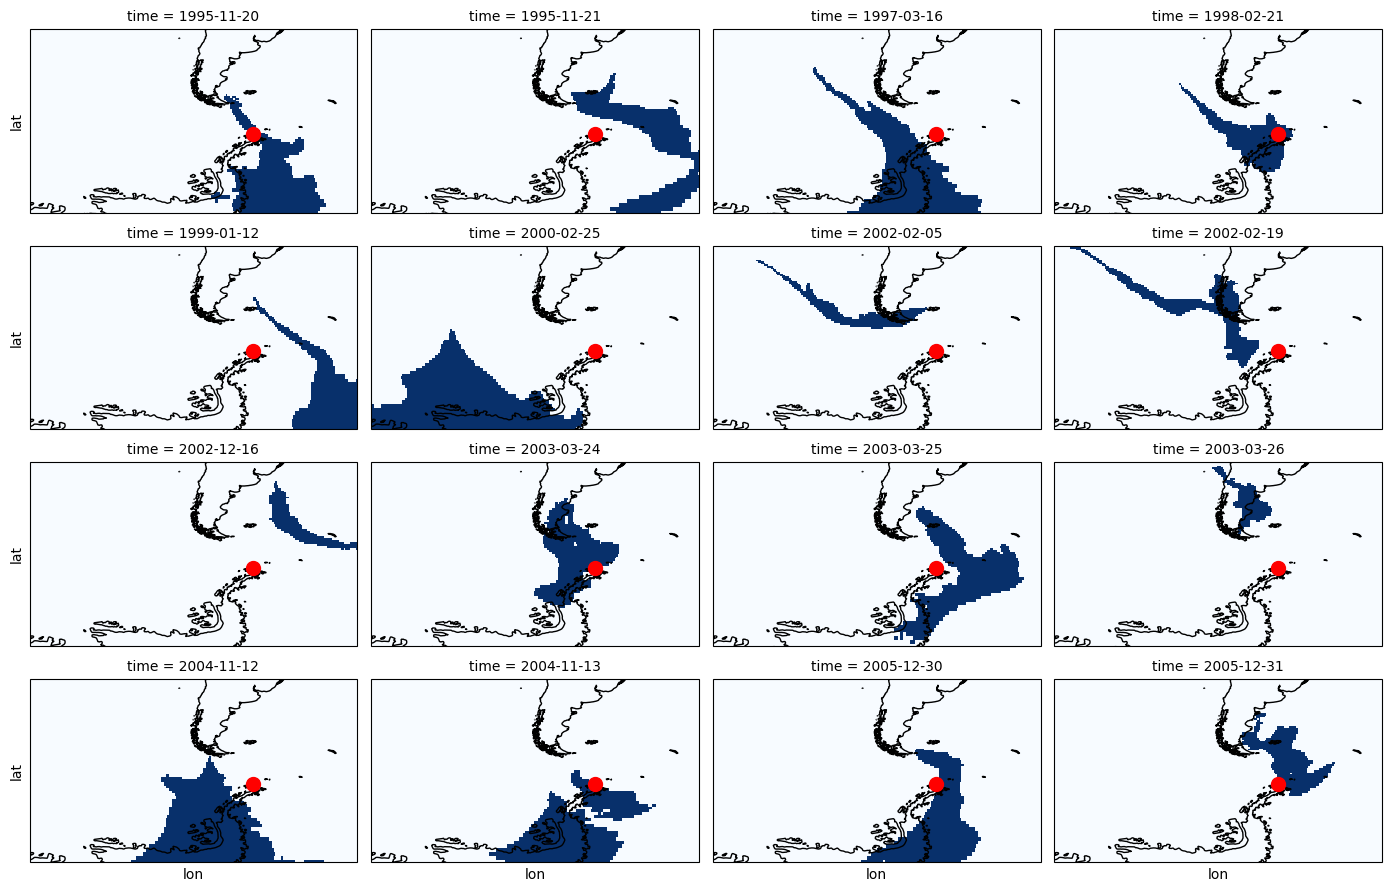

In [97]:
# Defina os limites desejados para latitudes e longitudes
lon_min, lon_max = -120, -30  # Ajuste conforme necessário
lat_min, lat_max = -75, -30    # Ajuste conforme necessário

# Coordenadas de localização da estação (exemplo)
station_lat = -62.235946  # Latitude da estação
station_lon = -58.613468  # Longitude da estação

# Cria o plot facetado com xarray, usando a projeção Mercator
g = ds_ARs.sel(time=filtered_df.date.values).enar_binary_tag.plot.imshow(
    x="lon", y="lat", col="time", col_wrap=4, robust=True,
    subplot_kws={'projection': ccrs.Mercator()},  # Projeção Mercator
    transform=ccrs.PlateCarree(), 
    add_colorbar=False,
    cmap='Blues',  # Usa o colormap "Blues"
    vmin=0, vmax=1  # Limita os valores para 0 (transparente) e 1 (azul)
)

# Ajustando o layout manualmente usando gridspec
fig = g.fig
fig.set_size_inches(14, 9)  # Ajuste o tamanho da figura para garantir que os subplots não se sobreponham

# Adiciona contornos de costas em cada subplot e define os limites de lat/lon
for ax in g.axes.flat:
    ax.coastlines()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Define o domínio de lat/lon
    ax.set_title(ax.get_title(), fontsize=10)

    # Ajusta a projeção para uma distribuição uniforme, ajustando o limite
    ax.set_aspect('auto')  # Ajusta automaticamente o aspecto dos subplots para uma melhor distribuição

    # Asegurando que el punto de la estación sea visible en el gráfico
    ax.scatter(station_lon, station_lat, color='red', s=100, marker='o', zorder=10, transform=ccrs.PlateCarree())

# Ajusta o espaçamento vertical e horizontal
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Ajuste os espaços entre as figuras

# Remover margens extras
for ax in g.axes.flat:
    ax.margins(0)  # Remove margens extras
    ax.set_xticks([])  # Remove os ticks do eixo x
    ax.set_yticks([])  # Remove os ticks do eixo y

# Ajuste do layout
fig.tight_layout(pad=1.0)
#fig.savefig('./fig/AP_HWs_ARs_SSI.pdf', dpi=500, facecolor='w', bbox_inches='tight', pad_inches=0.1)
# Mostrar a legenda
plt.show()